In [27]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [30]:
import pandas as pd
import os

In [31]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [32]:
file = pd.read_csv("heart.csv")
file.head()
file.values

array([[63.,  1.,  3., ...,  0.,  1.,  1.],
       [37.,  1.,  2., ...,  0.,  2.,  1.],
       [41.,  0.,  1., ...,  0.,  2.,  1.],
       ...,
       [68.,  1.,  0., ...,  2.,  3.,  0.],
       [57.,  1.,  0., ...,  1.,  3.,  0.],
       [57.,  0.,  1., ...,  1.,  2.,  0.]])

In [33]:
X = np.array(file.values[:,:-1])
X = StandardScaler().fit_transform(X)
y = np.array(file.values[:,-1]).reshape(-1,1).astype(int)

In [34]:
x_neg=X[165:303]
x_pos=X[0:165]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(138, 13)
(165, 13)


In [35]:
indices=np.arange(69)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:69]
x_train=np.concatenate((np.array(x_neg[0:69])[indices],x_pos)).reshape(-1,13)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [36]:
x_test = x_neg[69:138].reshape(-1,13)
y_test = y_neg[69:138].reshape(-1,1)

# Projection model

In [14]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [15]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create filter(sec): %f \n\n\n" % (m,fpr_test,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]

In [16]:
num_of_iterations = 20 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(165, 13)
Size: 10 Bits - FPR: 0.884058 - Time Taken to create filter(sec): 0.076546 



Size: 20 Bits - FPR: 0.826087 - Time Taken to create filter(sec): 0.056416 



Size: 30 Bits - FPR: 0.971014 - Time Taken to create filter(sec): 0.050917 



Size: 40 Bits - FPR: 0.797101 - Time Taken to create filter(sec): 0.057651 



Size: 50 Bits - FPR: 0.666667 - Time Taken to create filter(sec): 0.052655 



Size: 60 Bits - FPR: 0.710145 - Time Taken to create filter(sec): 0.048417 



Size: 70 Bits - FPR: 0.652174 - Time Taken to create filter(sec): 0.048689 



Size: 80 Bits - FPR: 0.695652 - Time Taken to create filter(sec): 0.048722 



Size: 90 Bits - FPR: 0.710145 - Time Taken to create filter(sec): 0.059027 



Size: 100 Bits - FPR: 0.463768 - Time Taken to create filter(sec): 0.051110 



Size: 110 Bits - FPR: 0.550725 - Time Taken to create filter(sec): 0.048563 



Size: 120 Bits - FPR: 0.637681 - Time Taken to create filter(sec): 0.046617 



Size: 1

Size: 1030 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.081162 



Size: 1040 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.074919 



Size: 1050 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.072320 



Size: 1060 Bits - FPR: 0.115942 - Time Taken to create filter(sec): 0.083928 



Size: 1070 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.074958 



Size: 1080 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.075642 



Size: 1090 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.078656 



Size: 1100 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.073909 



Size: 1110 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.075884 



Size: 1120 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.117111 



Size: 1130 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.202469 



Size: 1140 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.183177 



Size: 1150 Bits - FPR: 0.028

Size: 2050 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.121971 



Size: 2060 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125229 



Size: 2070 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.124913 



Size: 2080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.128375 



Size: 2090 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126533 



Size: 2100 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.126370 



Size: 2110 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.153349 



Size: 2120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142060 



Size: 2130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131253 



Size: 2140 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.193272 



Size: 2150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.199486 



Size: 2160 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.195898 



Size: 2170 Bits - FPR: 0.000

Size: 60 Bits - FPR: 0.608696 - Time Taken to create filter(sec): 0.079695 



Size: 70 Bits - FPR: 0.463768 - Time Taken to create filter(sec): 0.134992 



Size: 80 Bits - FPR: 0.376812 - Time Taken to create filter(sec): 0.079280 



Size: 90 Bits - FPR: 0.652174 - Time Taken to create filter(sec): 0.053773 



Size: 100 Bits - FPR: 0.521739 - Time Taken to create filter(sec): 0.050378 



Size: 110 Bits - FPR: 0.507246 - Time Taken to create filter(sec): 0.049366 



Size: 120 Bits - FPR: 0.579710 - Time Taken to create filter(sec): 0.049568 



Size: 130 Bits - FPR: 0.724638 - Time Taken to create filter(sec): 0.054728 



Size: 140 Bits - FPR: 0.420290 - Time Taken to create filter(sec): 0.055700 



Size: 150 Bits - FPR: 0.565217 - Time Taken to create filter(sec): 0.066720 



Size: 160 Bits - FPR: 0.347826 - Time Taken to create filter(sec): 0.064743 



Size: 170 Bits - FPR: 0.405797 - Time Taken to create filter(sec): 0.115036 



Size: 180 Bits - FPR: 0.347826 - Time Taken 

Size: 1090 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.113316 



Size: 1100 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.090395 



Size: 1110 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.126804 



Size: 1120 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.170818 



Size: 1130 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.141836 



Size: 1140 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.074528 



Size: 1150 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.075053 



Size: 1160 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.206995 



Size: 1170 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.323694 



Size: 1180 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.139097 



Size: 1190 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.087024 



Size: 1200 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.163160 



Size: 1210 Bits - FPR: 0.072

Size: 2120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111487 



Size: 2130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107677 



Size: 2140 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.112665 



Size: 2150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114422 



Size: 2160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.123821 



Size: 2170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115768 



Size: 2180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.119440 



Size: 2190 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.117482 



Size: 2200 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.124080 



Size: 2210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.123820 



Size: 2220 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.117124 



Size: 2230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.121861 



Size: 2240 Bits - FPR: 0.000

Size: 130 Bits - FPR: 0.637681 - Time Taken to create filter(sec): 0.048727 



Size: 140 Bits - FPR: 0.565217 - Time Taken to create filter(sec): 0.047959 



Size: 150 Bits - FPR: 0.449275 - Time Taken to create filter(sec): 0.051667 



Size: 160 Bits - FPR: 0.550725 - Time Taken to create filter(sec): 0.050201 



Size: 170 Bits - FPR: 0.405797 - Time Taken to create filter(sec): 0.049428 



Size: 180 Bits - FPR: 0.420290 - Time Taken to create filter(sec): 0.053751 



Size: 190 Bits - FPR: 0.420290 - Time Taken to create filter(sec): 0.052171 



Size: 200 Bits - FPR: 0.347826 - Time Taken to create filter(sec): 0.051206 



Size: 210 Bits - FPR: 0.434783 - Time Taken to create filter(sec): 0.057452 



Size: 220 Bits - FPR: 0.420290 - Time Taken to create filter(sec): 0.065152 



Size: 230 Bits - FPR: 0.391304 - Time Taken to create filter(sec): 0.060679 



Size: 240 Bits - FPR: 0.318841 - Time Taken to create filter(sec): 0.052145 



Size: 250 Bits - FPR: 0.362319 - Time Ta

Size: 1170 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.074576 



Size: 1180 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.072722 



Size: 1190 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.089773 



Size: 1200 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.116646 



Size: 1210 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.099249 



Size: 1220 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.082765 



Size: 1230 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.096607 



Size: 1240 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.085682 



Size: 1250 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.100481 



Size: 1260 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.086317 



Size: 1270 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.091282 



Size: 1280 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.081910 



Size: 1290 Bits - FPR: 0.014

Size: 2190 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.125673 



Size: 2200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116151 



Size: 2210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.128055 



Size: 2220 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.116496 



Size: 2230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131276 



Size: 2240 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142454 



Size: 2250 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.129409 



Size: 2260 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.120073 



Size: 2270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.140735 



Size: 2280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.139961 



Size: 2290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.152237 



Size: 2300 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.120679 



Size: 2310 Bits - FPR: 0.014

Size: 230 Bits - FPR: 0.449275 - Time Taken to create filter(sec): 0.061663 



Size: 240 Bits - FPR: 0.507246 - Time Taken to create filter(sec): 0.050587 



Size: 250 Bits - FPR: 0.391304 - Time Taken to create filter(sec): 0.048727 



Size: 260 Bits - FPR: 0.347826 - Time Taken to create filter(sec): 0.048864 



Size: 270 Bits - FPR: 0.391304 - Time Taken to create filter(sec): 0.048242 



Size: 280 Bits - FPR: 0.333333 - Time Taken to create filter(sec): 0.065239 



Size: 290 Bits - FPR: 0.434783 - Time Taken to create filter(sec): 0.050142 



Size: 300 Bits - FPR: 0.202899 - Time Taken to create filter(sec): 0.050683 



Size: 310 Bits - FPR: 0.463768 - Time Taken to create filter(sec): 0.048323 



Size: 320 Bits - FPR: 0.188406 - Time Taken to create filter(sec): 0.050571 



Size: 330 Bits - FPR: 0.202899 - Time Taken to create filter(sec): 0.063898 



Size: 340 Bits - FPR: 0.333333 - Time Taken to create filter(sec): 0.053065 



Size: 350 Bits - FPR: 0.289855 - Time Ta

Size: 1270 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.105009 



Size: 1280 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.088071 



Size: 1290 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.086715 



Size: 1300 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.122084 



Size: 1310 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.088007 



Size: 1320 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.088586 



Size: 1330 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.098668 



Size: 1340 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.092092 



Size: 1350 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.091496 



Size: 1360 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.097918 



Size: 1370 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.087245 



Size: 1380 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.094442 



Size: 1390 Bits - FPR: 0.028

Size: 2300 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142105 



Size: 2310 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.128356 



Size: 2320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.136300 



Size: 2330 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.123213 



Size: 2340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137742 



Size: 2350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.123338 



Size: 2360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134373 



Size: 2370 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.122252 



Size: 2380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.136582 



Size: 2390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133272 



Size: 2400 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.143335 



Size: 2410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134078 



Size: 2420 Bits - FPR: 0.000

Size: 350 Bits - FPR: 0.202899 - Time Taken to create filter(sec): 0.051381 



Size: 360 Bits - FPR: 0.420290 - Time Taken to create filter(sec): 0.066202 



Size: 370 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.058456 



Size: 380 Bits - FPR: 0.304348 - Time Taken to create filter(sec): 0.053391 



Size: 390 Bits - FPR: 0.202899 - Time Taken to create filter(sec): 0.056565 



Size: 400 Bits - FPR: 0.217391 - Time Taken to create filter(sec): 0.070284 



Size: 410 Bits - FPR: 0.260870 - Time Taken to create filter(sec): 0.056174 



Size: 420 Bits - FPR: 0.231884 - Time Taken to create filter(sec): 0.050344 



Size: 430 Bits - FPR: 0.275362 - Time Taken to create filter(sec): 0.054173 



Size: 440 Bits - FPR: 0.260870 - Time Taken to create filter(sec): 0.065082 



Size: 450 Bits - FPR: 0.231884 - Time Taken to create filter(sec): 0.055438 



Size: 460 Bits - FPR: 0.144928 - Time Taken to create filter(sec): 0.060186 



Size: 470 Bits - FPR: 0.188406 - Time Ta

Size: 1370 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.100149 



Size: 1380 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.088426 



Size: 1390 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.089082 



Size: 1400 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.097382 



Size: 1410 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.086930 



Size: 1420 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.088651 



Size: 1430 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.107145 



Size: 1440 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.096072 



Size: 1450 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.097909 



Size: 1460 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.107813 



Size: 1470 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.097162 



Size: 1480 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.096893 



Size: 1490 Bits - FPR: 0.014

Size: 2390 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.149026 



Size: 2400 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134894 



Size: 2410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144159 



Size: 2420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133289 



Size: 2430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144201 



Size: 2440 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.132584 



Size: 2450 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.142270 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133643 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143679 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134731 



Size: 2490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143086 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143883 



Size: 2510 Bits - FPR: 0.000

Size: 430 Bits - FPR: 0.217391 - Time Taken to create filter(sec): 0.050407 



Size: 440 Bits - FPR: 0.217391 - Time Taken to create filter(sec): 0.064641 



Size: 450 Bits - FPR: 0.231884 - Time Taken to create filter(sec): 0.051600 



Size: 460 Bits - FPR: 0.289855 - Time Taken to create filter(sec): 0.050021 



Size: 470 Bits - FPR: 0.260870 - Time Taken to create filter(sec): 0.050936 



Size: 480 Bits - FPR: 0.217391 - Time Taken to create filter(sec): 0.073748 



Size: 490 Bits - FPR: 0.260870 - Time Taken to create filter(sec): 0.062297 



Size: 500 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.063247 



Size: 510 Bits - FPR: 0.188406 - Time Taken to create filter(sec): 0.062778 



Size: 520 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.078175 



Size: 530 Bits - FPR: 0.202899 - Time Taken to create filter(sec): 0.064090 



Size: 540 Bits - FPR: 0.231884 - Time Taken to create filter(sec): 0.065682 



Size: 550 Bits - FPR: 0.217391 - Time Ta

Size: 1450 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.240580 



Size: 1460 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.131036 



Size: 1470 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.155683 



Size: 1480 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.116245 



Size: 1490 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.218006 



Size: 1500 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.154580 



Size: 1510 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.121580 



Size: 1520 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.129618 



Size: 1530 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.146232 



Size: 1540 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.163106 



Size: 1550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.151196 



Size: 1560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.136921 



Size: 1570 Bits - FPR: 0.014

Size: 2470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.217105 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.195378 



Size: 2490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.189470 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.208232 



Size: 2510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.197352 



Size: 2520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.189391 



Size: 2530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.195503 



Size: 2540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.183433 



Size: 2550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.183547 



Size: 2560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.200423 



Size: 2570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.234491 



Size: 2580 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.207725 



Size: 2590 Bits - FPR: 0.000

Size: 490 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.148608 



Size: 500 Bits - FPR: 0.202899 - Time Taken to create filter(sec): 0.119404 



Size: 510 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.098460 



Size: 520 Bits - FPR: 0.202899 - Time Taken to create filter(sec): 0.149087 



Size: 530 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.093616 



Size: 540 Bits - FPR: 0.246377 - Time Taken to create filter(sec): 0.086620 



Size: 550 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.095727 



Size: 560 Bits - FPR: 0.202899 - Time Taken to create filter(sec): 0.088414 



Size: 570 Bits - FPR: 0.115942 - Time Taken to create filter(sec): 0.083925 



Size: 580 Bits - FPR: 0.144928 - Time Taken to create filter(sec): 0.085869 



Size: 590 Bits - FPR: 0.173913 - Time Taken to create filter(sec): 0.091525 



Size: 600 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.086382 



Size: 610 Bits - FPR: 0.144928 - Time Ta

Size: 1520 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.216119 



Size: 1530 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.193167 



Size: 1540 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.213214 



Size: 1550 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.220178 



Size: 1560 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.214850 



Size: 1570 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.195360 



Size: 1580 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.182536 



Size: 1590 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.139507 



Size: 1600 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.130411 



Size: 1610 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.132889 



Size: 1620 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.133048 



Size: 1630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144431 



Size: 1640 Bits - FPR: 0.014

Size: 2550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.188951 



Size: 2560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.183724 



Size: 2570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.189391 



Size: 2580 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.191149 



Size: 2590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.188452 



Size: 2600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.188788 



Size: 2610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.183490 



Size: 2620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.197732 



Size: 2630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.204999 



Size: 2640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.337118 



Size: 2650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.316464 



Size: 2660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.293560 



Size: 2670 Bits - FPR: 0.014

Size: 570 Bits - FPR: 0.217391 - Time Taken to create filter(sec): 0.092021 



Size: 580 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.090375 



Size: 590 Bits - FPR: 0.289855 - Time Taken to create filter(sec): 0.126003 



Size: 600 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.150453 



Size: 610 Bits - FPR: 0.144928 - Time Taken to create filter(sec): 0.091543 



Size: 620 Bits - FPR: 0.202899 - Time Taken to create filter(sec): 0.081324 



Size: 630 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.086294 



Size: 640 Bits - FPR: 0.144928 - Time Taken to create filter(sec): 0.083120 



Size: 650 Bits - FPR: 0.173913 - Time Taken to create filter(sec): 0.078474 



Size: 660 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.085739 



Size: 670 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.088780 



Size: 680 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.096984 



Size: 690 Bits - FPR: 0.086957 - Time Ta

Size: 1600 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.132262 



Size: 1610 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.140801 



Size: 1620 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.135405 



Size: 1630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.138480 



Size: 1640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134304 



Size: 1650 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.139271 



Size: 1660 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.132455 



Size: 1670 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.155172 



Size: 1680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.148379 



Size: 1690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.147960 



Size: 1700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.150502 



Size: 1710 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.193639 



Size: 1720 Bits - FPR: 0.000

Size: 2630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.204026 



Size: 2640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.197080 



Size: 2650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.206160 



Size: 2660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.202695 



Size: 2670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.195796 



Size: 2680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.202644 



Size: 2690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.193250 



Size: 2700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.190272 



Size: 2710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.188114 



Size: 2720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.196386 



Size: 2730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.200078 



Size: 2740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.219111 



Size: 2750 Bits - FPR: 0.000

Size: 660 Bits - FPR: 0.144928 - Time Taken to create filter(sec): 0.102815 



Size: 670 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.084739 



Size: 680 Bits - FPR: 0.173913 - Time Taken to create filter(sec): 0.082578 



Size: 690 Bits - FPR: 0.188406 - Time Taken to create filter(sec): 0.091440 



Size: 700 Bits - FPR: 0.115942 - Time Taken to create filter(sec): 0.090923 



Size: 710 Bits - FPR: 0.246377 - Time Taken to create filter(sec): 0.089396 



Size: 720 Bits - FPR: 0.304348 - Time Taken to create filter(sec): 0.102209 



Size: 730 Bits - FPR: 0.144928 - Time Taken to create filter(sec): 0.101428 



Size: 740 Bits - FPR: 0.173913 - Time Taken to create filter(sec): 0.096092 



Size: 750 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.103306 



Size: 760 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.119122 



Size: 770 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.102307 



Size: 780 Bits - FPR: 0.072464 - Time Ta

Size: 1690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112031 



Size: 1700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110694 



Size: 1710 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.110654 



Size: 1720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.109730 



Size: 1730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110432 



Size: 1740 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.126658 



Size: 1750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114005 



Size: 1760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111982 



Size: 1770 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.113947 



Size: 1780 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.113002 



Size: 1790 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.116165 



Size: 1800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111427 



Size: 1810 Bits - FPR: 0.014

Size: 2720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.147466 



Size: 2730 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.140237 



Size: 2740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143746 



Size: 2750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.140971 



Size: 2760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.146351 



Size: 2770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.140426 



Size: 2780 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.144508 



Size: 2790 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.142435 



Size: 2800 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.143921 



Size: 2810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143025 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.145132 



Size: 2830 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.142601 



Size: 2840 Bits - FPR: 0.000

Size: 760 Bits - FPR: 0.202899 - Time Taken to create filter(sec): 0.073030 



Size: 770 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.071248 



Size: 780 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.069416 



Size: 790 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.072362 



Size: 800 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.071411 



Size: 810 Bits - FPR: 0.144928 - Time Taken to create filter(sec): 0.069376 



Size: 820 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.071821 



Size: 830 Bits - FPR: 0.173913 - Time Taken to create filter(sec): 0.071855 



Size: 840 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.069418 



Size: 850 Bits - FPR: 0.188406 - Time Taken to create filter(sec): 0.087183 



Size: 860 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.073657 



Size: 870 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.069907 



Size: 880 Bits - FPR: 0.115942 - Time Ta

Size: 1790 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.149016 



Size: 1800 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.147400 



Size: 1810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.146079 



Size: 1820 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.151020 



Size: 1830 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.145781 



Size: 1840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.146851 



Size: 1850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.149071 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.149952 



Size: 1870 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.151136 



Size: 1880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144328 



Size: 1890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.154207 



Size: 1900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.146701 



Size: 1910 Bits - FPR: 0.000

Size: 2810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.202448 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.231643 



Size: 2830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.213691 



Size: 2840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.194639 



Size: 2850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.199877 



Size: 2860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.222205 



Size: 2870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.230800 



Size: 2880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.217433 



Size: 2890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.219681 



Size: 2900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.218472 



Size: 2910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.219850 



Size: 2920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.219667 



Size: 2930 Bits - FPR: 0.000

Size: 840 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.116883 



Size: 850 Bits - FPR: 0.115942 - Time Taken to create filter(sec): 0.110811 



Size: 860 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.101729 



Size: 870 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.104169 



Size: 880 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.106107 



Size: 890 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.110337 



Size: 900 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.101724 



Size: 910 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.111177 



Size: 920 Bits - FPR: 0.115942 - Time Taken to create filter(sec): 0.163381 



Size: 930 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.140210 



Size: 940 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.125817 



Size: 950 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.128789 



Size: 960 Bits - FPR: 0.057971 - Time Ta

Size: 1860 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.148744 



Size: 1870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.149214 



Size: 1880 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.148489 



Size: 1890 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.149875 



Size: 1900 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.144381 



Size: 1910 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.156836 



Size: 1920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.158189 



Size: 1930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.157767 



Size: 1940 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.166784 



Size: 1950 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.149830 



Size: 1960 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.152416 



Size: 1970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.160179 



Size: 1980 Bits - FPR: 0.000

Size: 2880 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.206829 



Size: 2890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.298872 



Size: 2900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.282184 



Size: 2910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.298394 



Size: 2920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.345908 



Size: 2930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.285461 



Size: 2940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.214398 



Size: 2950 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.214233 



Size: 2960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.211653 



Size: 2970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.208671 



Size: 2980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.198794 



Size: 2990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.216907 



Size: 3000 Bits - FPR: 0.000

Size: 910 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.096242 



Size: 920 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.096409 



Size: 930 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.099265 



Size: 940 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.164952 



Size: 950 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.097137 



Size: 960 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.119688 



Size: 970 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.111451 



Size: 980 Bits - FPR: 0.115942 - Time Taken to create filter(sec): 0.109895 



Size: 990 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.107873 



Size: 1000 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.115433 



Size: 1010 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.115304 



Size: 1020 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.110567 



Size: 1030 Bits - FPR: 0.086957 - Tim

Size: 1940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.163821 



Size: 1950 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.162535 



Size: 1960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.158202 



Size: 1970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.157894 



Size: 1980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.156351 



Size: 1990 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.159439 



Size: 2000 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.162227 



Size: 2010 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.161047 



Size: 2020 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.163492 



Size: 2030 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.155925 



Size: 2040 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.165248 



Size: 2050 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.162431 



Size: 2060 Bits - FPR: 0.000

Size: 2960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.233791 



Size: 2970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.211833 



Size: 2980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.207027 



Size: 2990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.212126 



Size: 3000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.206135 



~~~~~~~~ Iteration 13 ~~~~~~~~ 

(165, 13)
Size: 10 Bits - FPR: 0.855072 - Time Taken to create filter(sec): 0.080745 



Size: 20 Bits - FPR: 0.782609 - Time Taken to create filter(sec): 0.080793 



Size: 30 Bits - FPR: 0.724638 - Time Taken to create filter(sec): 0.075048 



Size: 40 Bits - FPR: 0.695652 - Time Taken to create filter(sec): 0.072180 



Size: 50 Bits - FPR: 0.608696 - Time Taken to create filter(sec): 0.075388 



Size: 60 Bits - FPR: 0.536232 - Time Taken to create filter(sec): 0.073845 



Size: 70 Bits - FPR: 0.652174 - Time Taken to create filter(sec): 0.073554 




Size: 990 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.128912 



Size: 1000 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.113471 



Size: 1010 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.117277 



Size: 1020 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.108224 



Size: 1030 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.176540 



Size: 1040 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.111753 



Size: 1050 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.116871 



Size: 1060 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.109139 



Size: 1070 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.112785 



Size: 1080 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.112605 



Size: 1090 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.110404 



Size: 1100 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.112022 



Size: 1110 Bits - FPR: 0.0579

Size: 2020 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.162143 



Size: 2030 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.161944 



Size: 2040 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.251916 



Size: 2050 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.258223 



Size: 2060 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.251474 



Size: 2070 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.247053 



Size: 2080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.258694 



Size: 2090 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.157605 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.164312 



Size: 2110 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.157846 



Size: 2120 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.162682 



Size: 2130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.187854 



Size: 2140 Bits - FPR: 0.000

Size: 30 Bits - FPR: 0.739130 - Time Taken to create filter(sec): 0.076587 



Size: 40 Bits - FPR: 0.739130 - Time Taken to create filter(sec): 0.078773 



Size: 50 Bits - FPR: 0.565217 - Time Taken to create filter(sec): 0.069350 



Size: 60 Bits - FPR: 0.768116 - Time Taken to create filter(sec): 0.067484 



Size: 70 Bits - FPR: 0.550725 - Time Taken to create filter(sec): 0.084130 



Size: 80 Bits - FPR: 0.565217 - Time Taken to create filter(sec): 0.074473 



Size: 90 Bits - FPR: 0.463768 - Time Taken to create filter(sec): 0.068859 



Size: 100 Bits - FPR: 0.608696 - Time Taken to create filter(sec): 0.073950 



Size: 110 Bits - FPR: 0.478261 - Time Taken to create filter(sec): 0.074372 



Size: 120 Bits - FPR: 0.434783 - Time Taken to create filter(sec): 0.074952 



Size: 130 Bits - FPR: 0.521739 - Time Taken to create filter(sec): 0.072020 



Size: 140 Bits - FPR: 0.507246 - Time Taken to create filter(sec): 0.067452 



Size: 150 Bits - FPR: 0.420290 - Time Taken to 

Size: 1060 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.111487 



Size: 1070 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.110720 



Size: 1080 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.113228 



Size: 1090 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.115728 



Size: 1100 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.120288 



Size: 1110 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.114334 



Size: 1120 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.113731 



Size: 1130 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.104483 



Size: 1140 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.112219 



Size: 1150 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.108793 



Size: 1160 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.135929 



Size: 1170 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.106350 



Size: 1180 Bits - FPR: 0.072

Size: 2080 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.119721 



Size: 2090 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.117624 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.124353 



Size: 2110 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.119409 



Size: 2120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.119481 



Size: 2130 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.114870 



Size: 2140 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.156402 



Size: 2150 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.189143 



Size: 2160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.208011 



Size: 2170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.221320 



Size: 2180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.155141 



Size: 2190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.129874 



Size: 2200 Bits - FPR: 0.000

Size: 120 Bits - FPR: 0.391304 - Time Taken to create filter(sec): 0.084946 



Size: 130 Bits - FPR: 0.492754 - Time Taken to create filter(sec): 0.114976 



Size: 140 Bits - FPR: 0.478261 - Time Taken to create filter(sec): 0.077152 



Size: 150 Bits - FPR: 0.449275 - Time Taken to create filter(sec): 0.051742 



Size: 160 Bits - FPR: 0.405797 - Time Taken to create filter(sec): 0.049092 



Size: 170 Bits - FPR: 0.449275 - Time Taken to create filter(sec): 0.050013 



Size: 180 Bits - FPR: 0.521739 - Time Taken to create filter(sec): 0.050901 



Size: 190 Bits - FPR: 0.376812 - Time Taken to create filter(sec): 0.048220 



Size: 200 Bits - FPR: 0.449275 - Time Taken to create filter(sec): 0.051211 



Size: 210 Bits - FPR: 0.289855 - Time Taken to create filter(sec): 0.053195 



Size: 220 Bits - FPR: 0.231884 - Time Taken to create filter(sec): 0.050786 



Size: 230 Bits - FPR: 0.449275 - Time Taken to create filter(sec): 0.050125 



Size: 240 Bits - FPR: 0.362319 - Time Ta

Size: 1160 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.080002 



Size: 1170 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.084093 



Size: 1180 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.080165 



Size: 1190 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.083150 



Size: 1200 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.088734 



Size: 1210 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.091573 



Size: 1220 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.092087 



Size: 1230 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.088976 



Size: 1240 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.087071 



Size: 1250 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.091792 



Size: 1260 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.091057 



Size: 1270 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.095315 



Size: 1280 Bits - FPR: 0.072

Size: 2180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125965 



Size: 2190 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.128748 



Size: 2200 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.126151 



Size: 2210 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.126500 



Size: 2220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126692 



Size: 2230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.123044 



Size: 2240 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.151219 



Size: 2250 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122681 



Size: 2260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.136102 



Size: 2270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.146504 



Size: 2280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126219 



Size: 2290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.124342 



Size: 2300 Bits - FPR: 0.000

Size: 210 Bits - FPR: 0.405797 - Time Taken to create filter(sec): 0.054246 



Size: 220 Bits - FPR: 0.347826 - Time Taken to create filter(sec): 0.048932 



Size: 230 Bits - FPR: 0.347826 - Time Taken to create filter(sec): 0.054504 



Size: 240 Bits - FPR: 0.275362 - Time Taken to create filter(sec): 0.055177 



Size: 250 Bits - FPR: 0.289855 - Time Taken to create filter(sec): 0.051074 



Size: 260 Bits - FPR: 0.391304 - Time Taken to create filter(sec): 0.052936 



Size: 270 Bits - FPR: 0.376812 - Time Taken to create filter(sec): 0.049687 



Size: 280 Bits - FPR: 0.289855 - Time Taken to create filter(sec): 0.053517 



Size: 290 Bits - FPR: 0.304348 - Time Taken to create filter(sec): 0.048318 



Size: 300 Bits - FPR: 0.362319 - Time Taken to create filter(sec): 0.051607 



Size: 310 Bits - FPR: 0.304348 - Time Taken to create filter(sec): 0.048708 



Size: 320 Bits - FPR: 0.275362 - Time Taken to create filter(sec): 0.052937 



Size: 330 Bits - FPR: 0.289855 - Time Ta

Size: 1260 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.090742 



Size: 1270 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.087153 



Size: 1280 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.089232 



Size: 1290 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.089970 



Size: 1300 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.104876 



Size: 1310 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.104792 



Size: 1320 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.099032 



Size: 1330 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.089728 



Size: 1340 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.092107 



Size: 1350 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.087135 



Size: 1360 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.087996 



Size: 1370 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.101694 



Size: 1380 Bits - FPR: 0.043

Size: 2280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127989 



Size: 2290 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.122737 



Size: 2300 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.128388 



Size: 2310 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.125282 



Size: 2320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125723 



Size: 2330 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.152196 



Size: 2340 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.126795 



Size: 2350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126661 



Size: 2360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.165115 



Size: 2370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.167864 



Size: 2380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.169989 



Size: 2390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143303 



Size: 2400 Bits - FPR: 0.000

Size: 330 Bits - FPR: 0.202899 - Time Taken to create filter(sec): 0.054282 



Size: 340 Bits - FPR: 0.231884 - Time Taken to create filter(sec): 0.051802 



Size: 350 Bits - FPR: 0.318841 - Time Taken to create filter(sec): 0.052006 



Size: 360 Bits - FPR: 0.347826 - Time Taken to create filter(sec): 0.051070 



Size: 370 Bits - FPR: 0.188406 - Time Taken to create filter(sec): 0.053531 



Size: 380 Bits - FPR: 0.289855 - Time Taken to create filter(sec): 0.062997 



Size: 390 Bits - FPR: 0.275362 - Time Taken to create filter(sec): 0.053548 



Size: 400 Bits - FPR: 0.188406 - Time Taken to create filter(sec): 0.053448 



Size: 410 Bits - FPR: 0.202899 - Time Taken to create filter(sec): 0.050282 



Size: 420 Bits - FPR: 0.304348 - Time Taken to create filter(sec): 0.052210 



Size: 430 Bits - FPR: 0.275362 - Time Taken to create filter(sec): 0.056797 



Size: 440 Bits - FPR: 0.333333 - Time Taken to create filter(sec): 0.053355 



Size: 450 Bits - FPR: 0.391304 - Time Ta

Size: 1360 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.121333 



Size: 1370 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.099403 



Size: 1380 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.164407 



Size: 1390 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.089701 



Size: 1400 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.094904 



Size: 1410 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.105493 



Size: 1420 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.093610 



Size: 1430 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.141382 



Size: 1440 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.098999 



Size: 1450 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.099924 



Size: 1460 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.110660 



Size: 1470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098589 



Size: 1480 Bits - FPR: 0.014

Size: 2390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.190877 



Size: 2400 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132648 



Size: 2410 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.158914 



Size: 2420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.136737 



Size: 2430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.161656 



Size: 2440 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.134063 



Size: 2450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.160825 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.150427 



Size: 2470 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.147532 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143193 



Size: 2490 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.141966 



Size: 2500 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.160350 



Size: 2510 Bits - FPR: 0.000

Size: 430 Bits - FPR: 0.246377 - Time Taken to create filter(sec): 0.053532 



Size: 440 Bits - FPR: 0.188406 - Time Taken to create filter(sec): 0.059019 



Size: 450 Bits - FPR: 0.217391 - Time Taken to create filter(sec): 0.049296 



Size: 460 Bits - FPR: 0.318841 - Time Taken to create filter(sec): 0.050866 



Size: 470 Bits - FPR: 0.173913 - Time Taken to create filter(sec): 0.065667 



Size: 480 Bits - FPR: 0.347826 - Time Taken to create filter(sec): 0.063902 



Size: 490 Bits - FPR: 0.188406 - Time Taken to create filter(sec): 0.061396 



Size: 500 Bits - FPR: 0.246377 - Time Taken to create filter(sec): 0.060214 



Size: 510 Bits - FPR: 0.304348 - Time Taken to create filter(sec): 0.078711 



Size: 520 Bits - FPR: 0.188406 - Time Taken to create filter(sec): 0.065295 



Size: 530 Bits - FPR: 0.217391 - Time Taken to create filter(sec): 0.060624 



Size: 540 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.059861 



Size: 550 Bits - FPR: 0.275362 - Time Ta

Size: 1460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.117184 



Size: 1470 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.105777 



Size: 1480 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.119306 



Size: 1490 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.130885 



Size: 1500 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.111946 



Size: 1510 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.132504 



Size: 1520 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.125484 



Size: 1530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.099511 



Size: 1540 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.111856 



Size: 1550 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.099837 



Size: 1560 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.117648 



Size: 1570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.097569 



Size: 1580 Bits - FPR: 0.057

Size: 2490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.145456 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.139505 



Size: 2510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143544 



Size: 2520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.148512 



Size: 2530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.140528 



Size: 2540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.145393 



Size: 2550 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.136933 



Size: 2560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143199 



Size: 2570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.153026 



Size: 2580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131357 



Size: 2590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.145864 



Size: 2600 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.131061 



Size: 2610 Bits - FPR: 0.000

Size: 530 Bits - FPR: 0.115942 - Time Taken to create filter(sec): 0.106549 



Size: 540 Bits - FPR: 0.144928 - Time Taken to create filter(sec): 0.088152 



Size: 550 Bits - FPR: 0.115942 - Time Taken to create filter(sec): 0.094433 



Size: 560 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.107418 



Size: 570 Bits - FPR: 0.144928 - Time Taken to create filter(sec): 0.099132 



Size: 580 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.088358 



Size: 590 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.105470 



Size: 600 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.075257 



Size: 610 Bits - FPR: 0.246377 - Time Taken to create filter(sec): 0.071931 



Size: 620 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.062367 



Size: 630 Bits - FPR: 0.159420 - Time Taken to create filter(sec): 0.061081 



Size: 640 Bits - FPR: 0.072464 - Time Taken to create filter(sec): 0.060687 



Size: 650 Bits - FPR: 0.144928 - Time Ta

Size: 1550 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.108661 



Size: 1560 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.098317 



Size: 1570 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.097114 



Size: 1580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113645 



Size: 1590 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.108672 



Size: 1600 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.109885 



Size: 1610 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.100167 



Size: 1620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095507 



Size: 1630 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.112676 



Size: 1640 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.096267 



Size: 1650 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.095451 



Size: 1660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111123 



Size: 1670 Bits - FPR: 0.014

Size: 2580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.146472 



Size: 2590 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.139181 



Size: 2600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135419 



Size: 2610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143627 



Size: 2620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143236 



Size: 2630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.152122 



Size: 2640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142872 



Size: 2650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.154501 



Size: 2660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.154915 



Size: 2670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144869 



Size: 2680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.152987 



Size: 2690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.140730 



Size: 2700 Bits - FPR: 0.000

Size: 610 Bits - FPR: 0.144928 - Time Taken to create filter(sec): 0.064478 



Size: 620 Bits - FPR: 0.173913 - Time Taken to create filter(sec): 0.062832 



Size: 630 Bits - FPR: 0.217391 - Time Taken to create filter(sec): 0.068400 



Size: 640 Bits - FPR: 0.101449 - Time Taken to create filter(sec): 0.077073 



Size: 650 Bits - FPR: 0.115942 - Time Taken to create filter(sec): 0.095465 



Size: 660 Bits - FPR: 0.173913 - Time Taken to create filter(sec): 0.095005 



Size: 670 Bits - FPR: 0.144928 - Time Taken to create filter(sec): 0.062303 



Size: 680 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.060275 



Size: 690 Bits - FPR: 0.115942 - Time Taken to create filter(sec): 0.059273 



Size: 700 Bits - FPR: 0.086957 - Time Taken to create filter(sec): 0.069733 



Size: 710 Bits - FPR: 0.130435 - Time Taken to create filter(sec): 0.064306 



Size: 720 Bits - FPR: 0.057971 - Time Taken to create filter(sec): 0.069530 



Size: 730 Bits - FPR: 0.101449 - Time Ta

Size: 1630 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.110789 



Size: 1640 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.102357 



Size: 1650 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.112565 



Size: 1660 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.096183 



Size: 1670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.117318 



Size: 1680 Bits - FPR: 0.043478 - Time Taken to create filter(sec): 0.105434 



Size: 1690 Bits - FPR: 0.028986 - Time Taken to create filter(sec): 0.118268 



Size: 1700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110308 



Size: 1710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125434 



Size: 1720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.106847 



Size: 1730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122128 



Size: 1740 Bits - FPR: 0.014493 - Time Taken to create filter(sec): 0.107050 



Size: 1750 Bits - FPR: 0.014

Size: 2650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144642 



Size: 2660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142345 



Size: 2670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.145648 



Size: 2680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.155282 



Size: 2690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.150104 



Size: 2700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.153170 



Size: 2710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.150671 



Size: 2720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144123 



Size: 2730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143046 



Size: 2740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.141716 



Size: 2750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144868 



Size: 2760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142452 



Size: 2770 Bits - FPR: 0.000

In [17]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [18]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


# Normal Bloom Filter Values

In [19]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [20]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

6000
[165]


# FPR Comparison between Projection Model and Normal Bloom Filter

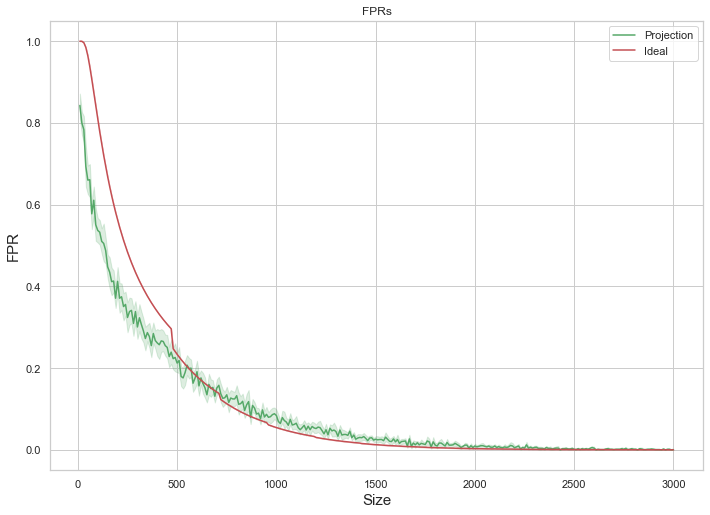

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [22]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

6000


In [23]:
average_times = num_of_iterations*average_times
print(len(average_times))

6000


In [24]:
print(average_fprs)

[0.8427536231884059, 0.8, 0.7833333333333334, 0.6934782608695652, 0.6601449275362319, 0.6608695652173913, 0.5775362318840581, 0.6108695652173912, 0.5507246376811594, 0.5369565217391304, 0.532608695652174, 0.510144927536232, 0.5050724637681159, 0.48768115942028983, 0.4478260869565217, 0.43478260869565216, 0.41159420289855075, 0.4130434782608695, 0.37101449275362314, 0.41231884057971013, 0.3710144927536233, 0.3746376811594202, 0.3507246376811594, 0.3557971014492754, 0.3239130434782609, 0.3384057971014493, 0.341304347826087, 0.30942028985507253, 0.33840579710144925, 0.3007246376811595, 0.32318840579710145, 0.30652173913043484, 0.29130434782608694, 0.27246376811594203, 0.28695652173913044, 0.277536231884058, 0.255072463768116, 0.2847826086956522, 0.26739130434782615, 0.26159420289855073, 0.25724637681159424, 0.2666666666666667, 0.26521739130434785, 0.255072463768116, 0.2507246376811595, 0.22826086956521738, 0.23913043478260873, 0.22318840579710147, 0.22608695652173916, 0.21231884057971012,

In [25]:
saved_data = list(zip(size_values, y_ideal, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,1.000000,0.884058,0.842754,0.076546,0.076238
1,20,0.999789,0.826087,0.800000,0.056416,0.074100
2,30,0.996279,0.971014,0.783333,0.050917,0.064014
3,40,0.984662,0.797101,0.693478,0.057651,0.065367
4,50,0.964330,0.666667,0.660145,0.052655,0.066398


In [26]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/Heart_rerun_epochs_100.csv')